In [254]:
# import necessary libraries
import os
import zipfile
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

In [19]:
# read data from zipped file
def read_data():
    zip_path = 'condition+monitoring+of+hydraulic+systems.zip'
    extract_path = './data'

    with zipfile.ZipFile(zip_path,'r') as zip_ref:
        zip_ref.extractall(extract_path)

    dataframes = {}
    for file in os.listdir(extract_path):
        file_path =  os.path.join(extract_path,file)

        try:
            df = pd.read_csv(file_path, delimiter='\t',header=None)
            dataframes[file] = df
            print(f'✅ successfully loaded {file}')

        except UnicodeDecodeError:
            print(f'{file} is not in csv format❌')  
    return dataframes

dataframes = read_data()

✅ successfully loaded SE.txt
✅ successfully loaded PS1.txt
✅ successfully loaded TS4.txt
✅ successfully loaded PS2.txt
✅ successfully loaded PS3.txt
✅ successfully loaded TS3.txt
✅ successfully loaded VS1.txt
✅ successfully loaded TS2.txt
✅ successfully loaded PS6.txt
✅ successfully loaded PS4.txt
documentation.txt is not in csv format❌
✅ successfully loaded TS1.txt
✅ successfully loaded PS5.txt
✅ successfully loaded CP.txt
✅ successfully loaded CE.txt
description.txt is not in csv format❌
✅ successfully loaded EPS1.txt
✅ successfully loaded FS1.txt
✅ successfully loaded FS2.txt
✅ successfully loaded profile.txt


In [20]:
#Preparing data for sql database
def rename_profile_columns():
    for key, value in dataframes.items():
        if key == 'profile.txt':
            value.columns = ['Cooler_Condition','Valve_Condition','Pump_Leakage','Accumulator_Condition','Stable_Flag']

rename_profile_columns()

def reindex_rows():
    for key, value in dataframes.items():
        index = range(1,(len(value+1)))
        dataframes[key] = value.reindex()

reindex_rows()

def check_for_missing_values():
    for key,value in dataframes.items():
        number_missing = value.isnull().sum().sum()
        print(f'{key} has {number_missing} missing values')

check_for_missing_values()

def convert_data_types():
    """Converts all columns to float if possible."""
    print('Convert data to floats')
    print('processing.....')
    for key,value in dataframes.items():
        value = value.apply(pd.to_numeric, errors="coerce")  # Convert to float, set errors as NaN
        dataframes[key] = value    
        print(f'{key} has been converted')
convert_data_types ()       



SE.txt has 0 missing values
PS1.txt has 0 missing values
TS4.txt has 0 missing values
PS2.txt has 0 missing values
PS3.txt has 0 missing values
TS3.txt has 0 missing values
VS1.txt has 0 missing values
TS2.txt has 0 missing values
PS6.txt has 0 missing values
PS4.txt has 0 missing values
TS1.txt has 0 missing values
PS5.txt has 0 missing values
CP.txt has 0 missing values
CE.txt has 0 missing values
EPS1.txt has 0 missing values
FS1.txt has 0 missing values
FS2.txt has 0 missing values
profile.txt has 0 missing values
Convert data to floats
processing.....
SE.txt has been converted
PS1.txt has been converted
TS4.txt has been converted
PS2.txt has been converted
PS3.txt has been converted
TS3.txt has been converted
VS1.txt has been converted
TS2.txt has been converted
PS6.txt has been converted
PS4.txt has been converted
TS1.txt has been converted
PS5.txt has been converted
CP.txt has been converted
CE.txt has been converted
EPS1.txt has been converted
FS1.txt has been converted
FS2.txt

In [21]:
# resample all datasets to 100Hz, part of the preparing data for database
def resample_to_100Hz():
    """
    Resamples multiple datasets to 100 Hz (6000 columns), except 'profile.txt'.

    Parameters:
    dataframes (dict): Dictionary where:
        - Keys = dataset names (e.g., "cooler", "valve", "pump")
        - Values = DataFrames (Rows = Cycle numbers, Columns = Time intervals)

    Returns:
    dict: Dictionary with resampled DataFrames.
    """
    resampled_data = {}  # Dictionary to store resampled datasets
    target_columns = 6000  # Standardized column size for 100Hz

    for key, df in dataframes.items():
        if key == 'profile.txt':  # Skip this dataset
            print(f"Skipping {key}")
            resampled_data[key] = df
            continue

        num_original_columns = df.shape[1]  # Get current number of time steps

        if num_original_columns == target_columns:
            print(f"{key} is already at 100 Hz, no resampling needed.")
            resampled_data[key] = df  # Keep original data
            continue

        # Create time indices for interpolation
        old_index = np.linspace(0, 1, num_original_columns)  # Original time scale
        new_index = np.linspace(0, 1, target_columns)  # Target time scale (6000 points)

        # Apply cubic interpolation for each row (cycle)
        resampled_df = pd.DataFrame(
            np.array([np.interp(new_index, old_index, row) for row in df.values]),
            index=df.index  # Keep original cycle numbers
        )

        resampled_data[key] = resampled_df  # Store resampled data
        print(f"{key} resampled from {num_original_columns} to {target_columns} columns.")
        print(f"New shape: {resampled_df.shape}")

    return resampled_data  # Return resampled dictionary
dataframes = resample_to_100Hz()

SE.txt resampled from 60 to 6000 columns.
New shape: (2205, 6000)
PS1.txt is already at 100 Hz, no resampling needed.
TS4.txt resampled from 60 to 6000 columns.
New shape: (2205, 6000)
PS2.txt is already at 100 Hz, no resampling needed.
PS3.txt is already at 100 Hz, no resampling needed.
TS3.txt resampled from 60 to 6000 columns.
New shape: (2205, 6000)
VS1.txt resampled from 60 to 6000 columns.
New shape: (2205, 6000)
TS2.txt resampled from 60 to 6000 columns.
New shape: (2205, 6000)
PS6.txt is already at 100 Hz, no resampling needed.
PS4.txt is already at 100 Hz, no resampling needed.
TS1.txt resampled from 60 to 6000 columns.
New shape: (2205, 6000)
PS5.txt is already at 100 Hz, no resampling needed.
CP.txt resampled from 60 to 6000 columns.
New shape: (2205, 6000)
CE.txt resampled from 60 to 6000 columns.
New shape: (2205, 6000)
EPS1.txt is already at 100 Hz, no resampling needed.
FS1.txt resampled from 600 to 6000 columns.
New shape: (2205, 6000)
FS2.txt resampled from 600 to 6000

In [28]:
# After creating database and table on PgAdmin, load the datasets into the database accordingly
def load_data_into_DB():
    # PostgreSQL Connection
    conn = psycopg2.connect(
        dbname="predictive_maintenance",
        user="postgres",
        password="20151102",
        host="localhost",
        port="5433"
    )
    cur = conn.cursor()

    table_mapping = {
        "TS1.txt": "Temperature",
        "TS2.txt": "Temperature",
        "TS3.txt": "Temperature",
        "TS4.txt": "Temperature",
        "PS1.txt": "Pressure",
        "PS2.txt": "Pressure",
        "PS3.txt": "Pressure",
        "PS4.txt": "Pressure",
        "PS5.txt": "Pressure",
        "PS6.txt": "Pressure",
        "FS1.txt": "Flow_Sensor",
        "FS2.txt": "Flow_Sensor",
        "CE.txt": "Cooling_Efficiency",
        "SE.txt": "Stable_Efficiency",
        "CP.txt": "Cooling_Power",
        "EPS1.txt": "Efficiency_Power_Signal",
        "VS1.txt": "Vibration_Sensor",
        "profile.txt": "Profile"
    }

    # Sensor Mapping (Assign SensorIDs)
    sensor_mapping = {
        "TS1.txt": 1, "TS2.txt": 2, "TS3.txt": 3, "TS4.txt": 4,
        "PS1.txt": 5, "PS2.txt": 6, "PS3.txt": 7, "PS4.txt": 8, "PS5.txt": 9, "PS6.txt": 10,
        "FS1.txt": 11, "FS2.txt": 12
    }


    # Step 2: Populate Cycle Table
    max_cycles = max(len(df) for df in dataframes.values())  # Find max number of cycles
    cur.executemany("INSERT INTO Cycle (CycleID) VALUES (%s) ON CONFLICT DO NOTHING;", [(i,) for i in range(1, max_cycles + 1)])
    conn.commit()
    print(f"Inserted {max_cycles} rows into Cycle table")

    # Step 1: Populate the Sensor Table First**
    sensor_values = [(s_id, s_type) for s_type, s_id in sensor_mapping.items()]
    cur.executemany(
        "INSERT INTO Sensor (SensorID, Sensor_type) VALUES (%s, %s) ON CONFLICT DO NOTHING",
        sensor_values
    )
    conn.commit()
    print(f"Inserted {len(sensor_values)} rows into Sensor table.")

    # Step 3: Populate the Profile Table


    # Step 2: Insert Data into Tables
    for key, df in sorted(dataframes.items()):
        if key != 'profile.txt':
            table_name = table_mapping[key]  # Convert filename to table name
            

            # Sensor-based tables (Temperature, Pressure, Flow_Sensor)
            if key in sensor_mapping:
                sensor_id = sensor_mapping[key]
                values = [
                    (idx, sensor_id, json.dumps({str(int(k.lstrip("_")) + 1): v for k, v in row._asdict().items()}))  # Convert row to JSON
                    for idx, row in enumerate(df.itertuples(index=False), start=1)  # Use row index as CycleID
                ]
                
                insert_query = f"""
                INSERT INTO {table_name} (CycleID, SensorID, {table_name}_data) VALUES (%s, %s, %s)
                """
                cur.executemany(insert_query, values)
                conn.commit()
                print(f"Inserted {len(values)} rows into {table_name}")

            # Non-Sensor tables
            else:
                values = [
                    (idx, json.dumps({str(int(k.lstrip("_")) + 1): v for k, v in row._asdict().items()}))
                    for idx, row in enumerate(df.itertuples(index=False), start=1)
                ]
                
                insert_query = f"""
                INSERT INTO {table_name} (CycleID, {table_name}_data) VALUES (%s, %s)
                """
                cur.executemany(insert_query, values)
                conn.commit()
                print(f"Inserted {len(values)} rows into {table_name}")
        else:
            values = [
            (
            idx,  # CycleID (assuming df_profile rows align with CycleID)
            int(row.Cooler_Condition),
            int(row.Valve_Condition),
            int(row.Pump_Leakage),
            int(row.Accumulator_Condition),
            bool(row.Stable_Flag)  # Convert to boolean
            )
            for idx, row in enumerate(df.itertuples(index=False), start=1)
            ]

            # SQL Insert Query
            insert_query = """
            INSERT INTO Profile (CycleID, Cooler_Condition, Valve_Condition, Pump_Leakage, Accumulator_Condition, Stable_Flag)
            VALUES (%s, %s, %s, %s, %s, %s)
            ON CONFLICT (CycleID) DO NOTHING;
            """

            # Execute insertion
            cur.executemany(insert_query, values)
            conn.commit()

    print(f"Inserted {len(values)} rows into Profile table.")        

    # Close Connection
    cur.close()
    conn.close()

load_data_into_DB()    

Inserted 2205 rows into Cycle table
Inserted 12 rows into Sensor table.
Inserted 2205 rows into Cooling_Efficiency
Inserted 2205 rows into Cooling_Power
Inserted 2205 rows into Efficiency_Power_Signal
Inserted 2205 rows into Flow_Sensor
Inserted 2205 rows into Flow_Sensor
Inserted 2205 rows into Pressure
Inserted 2205 rows into Pressure
Inserted 2205 rows into Pressure
Inserted 2205 rows into Pressure
Inserted 2205 rows into Pressure
Inserted 2205 rows into Pressure
Inserted 2205 rows into Stable_Efficiency
Inserted 2205 rows into Temperature
Inserted 2205 rows into Temperature
Inserted 2205 rows into Temperature
Inserted 2205 rows into Temperature
Inserted 2205 rows into Vibration_Sensor
Inserted 2205 rows into Profile table.


In [70]:
# after creating indexes and optimizing sql, query the data from the database into panda
def load_into_pandas():

    # Database connection details
    conn = psycopg2.connect(
        dbname="predictive_maintenance",
        user="postgres",
        password="20151102",
        host="localhost",
        port="5433"
    )

    # Connect to PostgreSQL
    cursor = conn.cursor()

    # Define chunk size
    chunk_size = 63
    total_rows = 2205
    num_chunks = total_rows // chunk_size  # Should be 35 (2205 / 63)

    chunks = []

    for i in range(num_chunks):
        offset = i * chunk_size  # Calculate the offset for pagination
        query = f"""
            WITH 
                -- Aggregate Pressure readings by CycleID
                Pressure_Agg AS (
                    SELECT CycleID, ARRAY_AGG(Pressure_data) AS Pressure_Readings 
                    FROM Pressure 
                    GROUP BY CycleID
                    ORDER BY CycleID
                    LIMIT {chunk_size} OFFSET {offset}
                ),

                -- Aggregate Temperature readings by CycleID
                Temperature_Agg AS (
                    SELECT CycleID, ARRAY_AGG(Temperature_data) AS Temperature_Readings 
                    FROM Temperature 
                    GROUP BY CycleID
                    ORDER BY CycleID
                    LIMIT {chunk_size} OFFSET {offset}
                ),

                -- Aggregate Flow Sensor readings by CycleID
                Flow_Agg AS (
                    SELECT CycleID, ARRAY_AGG(Flow_Sensor_data) AS Flow_Sensor_Readings 
                    FROM Flow_Sensor 
                    GROUP BY CycleID
                    ORDER BY CycleID
                ),

                -- Aggregate Stable Efficiency readings by CycleID
                Stable_Agg AS (
                    SELECT CycleID, ARRAY_AGG(Stable_Efficiency_data) AS Stable_Efficiency_Readings 
                    FROM Stable_Efficiency 
                    GROUP BY CycleID
                    ORDER BY CycleID
                    LIMIT {chunk_size} OFFSET {offset}
                ),

                -- Aggregate Cooling Efficiency readings by CycleID
                Cooling_Eff_Agg AS (
                    SELECT CycleID, ARRAY_AGG(Cooling_Efficiency_data) AS Cooling_Efficiency_Readings 
                    FROM Cooling_Efficiency 
                    GROUP BY CycleID
                    ORDER BY CycleID
                    LIMIT {chunk_size} OFFSET {offset}
                ),

                -- Aggregate Cooling Power readings by CycleID
                Cooling_Power_Agg AS (
                    SELECT CycleID, ARRAY_AGG(Cooling_Power_data) AS Cooling_Power_Readings 
                    FROM Cooling_Power 
                    GROUP BY CycleID
                    ORDER BY CycleID
                    LIMIT {chunk_size} OFFSET {offset}
                ),

                -- Aggregate Vibration Sensor readings by CycleID
                Vibration_Agg AS (
                    SELECT CycleID, ARRAY_AGG(Vibration_Sensor_data) AS Vibration_Sensor_Readings 
                    FROM Vibration_Sensor 
                    GROUP BY CycleID
                    ORDER BY CycleID
                    LIMIT {chunk_size} OFFSET {offset}
                ),

                -- Aggregate Efficiency Power Signal readings by CycleID
                Efficiency_Agg AS (
                    SELECT CycleID, ARRAY_AGG(Efficiency_Power_Signal_data) AS Efficiency_Power_Signal_Readings 
                    FROM Efficiency_Power_Signal 
                    GROUP BY CycleID
                    ORDER BY CycleID
                    LIMIT {chunk_size} OFFSET {offset}
                )

                SELECT 
                    c.CycleID,
                    p.Pressure_Readings,
                    t.Temperature_Readings,
                    fs.Flow_Sensor_Readings,
                    se.Stable_Efficiency_Readings,
                    ce.Cooling_Efficiency_Readings,
                    cp.Cooling_Power_Readings,
                    vs.Vibration_Sensor_Readings,
                    eps.Efficiency_Power_Signal_Readings,
                    pf.Cooler_Condition,
                    pf.Valve_Condition,
                    pf.Pump_Leakage,
                    pf.Accumulator_Condition,
                    pf.Stable_Flag
                FROM Cycle c
                INNER JOIN Pressure_Agg p ON c.CycleID = p.CycleID
                INNER JOIN Temperature_Agg t ON c.CycleID = t.CycleID
                INNER JOIN Flow_Agg fs ON c.CycleID = fs.CycleID
                INNER JOIN Stable_Agg se ON c.CycleID = se.CycleID
                INNER JOIN Cooling_Eff_Agg ce ON c.CycleID = ce.CycleID
                INNER JOIN Cooling_Power_Agg cp ON c.CycleID = cp.CycleID
                INNER JOIN Vibration_Agg vs ON c.CycleID = vs.CycleID
                INNER JOIN Efficiency_Agg eps ON c.CycleID = eps.CycleID
                INNER JOIN Profile pf ON c.CycleID = pf.CycleID;
        """

        # Execute query
        cursor.execute(query)
        
        # Fetch data
        colnames = [desc[0] for desc in cursor.description]  # Get column names
        rows = cursor.fetchall()  # Get results
        
        # Convert chunk to Pandas DataFrame
        chunk_df = pd.DataFrame(rows, columns=colnames)
        chunks.append(chunk_df)
        print(f'dataframe {i+1} has been loaded successfully')

    # Merge all chunks into a single DataFrame
    df = pd.concat(chunks, ignore_index=True)

    # Verify row count
    assert df.shape[0] == total_rows, f"Expected {total_rows} rows, got {df.shape[0]}"

    # Close connection
    cursor.close()
    conn.close()

    return df 


In [71]:
df = load_into_pandas()

dataframe 1 has been loaded successfully
dataframe 2 has been loaded successfully
dataframe 3 has been loaded successfully
dataframe 4 has been loaded successfully
dataframe 5 has been loaded successfully
dataframe 6 has been loaded successfully
dataframe 7 has been loaded successfully
dataframe 8 has been loaded successfully
dataframe 9 has been loaded successfully
dataframe 10 has been loaded successfully
dataframe 11 has been loaded successfully
dataframe 12 has been loaded successfully
dataframe 13 has been loaded successfully
dataframe 14 has been loaded successfully
dataframe 15 has been loaded successfully
dataframe 16 has been loaded successfully
dataframe 17 has been loaded successfully
dataframe 18 has been loaded successfully
dataframe 19 has been loaded successfully
dataframe 20 has been loaded successfully
dataframe 21 has been loaded successfully
dataframe 22 has been loaded successfully
dataframe 23 has been loaded successfully
dataframe 24 has been loaded successfully
d

In [255]:
#Preprocessing entire dataframe
# keeping only stable cycles for Modelling
def stable_cycles():
    df_stable = df[df['stable_flag']==True]
    df_stable = df_stable.set_index('cycleid')
    return df_stable
df_stable = stable_cycles()    

# Checking for missing values
def checking_for_missing_values():
    print(df_stable.isnull().sum())
checking_for_missing_values() 

# Splitting aggregate columns with multiple readings e.g pressure_readings_1 - 6, temperature_readings_1 - 4 etc.
def split_columns():
    df_copy = df_stable.copy()
    for column_name in df_copy:
        if df_copy[column_name].apply(lambda x: isinstance(x, list)).all():
            # Get the number of dictionaries in the first row (assuming all rows have the same structure)
            num_dicts = df_copy[column_name].apply(len).unique()[0]
            df_copy[[f'{column_name}_{i+1}' for i in range(num_dicts)]] = pd.DataFrame(df_copy[column_name].tolist(),index = df_copy.index)
            df_copy.drop(columns=[column_name],inplace=True)  
    return df_copy              
split_columns()

df_split = split_columns()

# this function splits the dataset into features and target columns for ML 
def split_columns_into_features_and_target_columns(df_stable_reindexed):
    labelled_columns = ['cooler_condition','valve_condition','pump_leakage','accumulator_condition','stable_flag']
    X = df_stable_reindexed.drop(columns = labelled_columns)
    y = df_stable_reindexed[labelled_columns]
    return X,y

X,y = split_columns_into_features_and_target_columns(df_split)

pressure_readings                   0
temperature_readings                0
flow_sensor_readings                0
stable_efficiency_readings          0
cooling_efficiency_readings         0
cooling_power_readings              0
vibration_sensor_readings           0
efficiency_power_signal_readings    0
cooler_condition                    0
valve_condition                     0
pump_leakage                        0
accumulator_condition               0
stable_flag                         0
dtype: int64


In [256]:
X.head()

,pressure_readings_1,pressure_readings_2,pressure_readings_3,pressure_readings_4,pressure_readings_5,pressure_readings_6,temperature_readings_1,temperature_readings_2,temperature_readings_3,temperature_readings_4,flow_sensor_readings_1,flow_sensor_readings_2,stable_efficiency_readings_1,cooling_efficiency_readings_1,cooling_power_readings_1,vibration_sensor_readings_1,efficiency_power_signal_readings_1
cycleid,,,,,,,,,,,,,,,,,
1,"{'1': 151.47, '2': 151.45, '3': 151.52, '4': 1...","{'1': 125.5, '2': 125.39, '3': 125.4, '4': 125...","{'1': 2.305, '2': 2.305, '3': 2.336, '4': 2.57...","{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...","{'1': 9.936, '2': 9.947, '3': 9.964, '4': 9.98...","{'1': 9.818, '2': 9.823, '3': 9.844, '4': 9.86...","{'1': 35.57, '2': 35.569232872145356, '3': 35....","{'1': 40.961, '2': 40.96088198033005, '3': 40....","{'1': 38.32, '2': 38.32011801966995, '3': 38.3...","{'1': 30.363, '2': 30.363118019669944, '3': 30...","{'1': 8.99, '2': 8.169233205534256, '3': 7.348...","{'1': 10.179, '2': 10.178500750125021, '3': 10...","{'1': 68.039, '2': 67.3698383063844, '3': 66.7...","{'1': 47.202, '2': 47.20269828304717, '3': 47....","{'1': 2.184, '2': 2.184, '3': 2.184, '4': 2.18...","{'1': 0.604, '2': 0.6040098349724954, '3': 0.6...","{'1': 2411.6, '2': 2411.6, '3': 2411.6, '4': 2..."
2,"{'1': 151.11, '2': 151.12, '3': 151.16, '4': 1...","{'1': 125.06, '2': 125.08, '3': 125.09, '4': 1...","{'1': 2.281, '2': 2.32, '3': 2.305, '4': 2.578...","{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...","{'1': 9.7, '2': 9.687, '3': 9.682, '4': 9.696,...","{'1': 9.592, '2': 9.573, '3': 9.578, '4': 9.58...","{'1': 36.156, '2': 36.15539023170528, '3': 36....","{'1': 41.258, '2': 41.258186864477416, '3': 41...","{'1': 38.68, '2': 38.67992132022004, '3': 38.6...","{'1': 33.648, '2': 33.64873762293716, '3': 33....","{'1': 8.919, '2': 8.109815802633772, '3': 7.30...","{'1': 10.408, '2': 10.410096849474913, '3': 10...","{'1': 68.264, '2': 67.59262543757292, '3': 66....","{'1': 29.208, '2': 29.20420370061677, '3': 29....","{'1': 1.414, '2': 1.4137049508251374, '3': 1.4...","{'1': 0.59, '2': 0.5901966994499083, '3': 0.59...","{'1': 2409.6, '2': 2409.6, '3': 2409.6, '4': 2..."
3,"{'1': 150.81, '2': 150.79, '3': 150.84, '4': 1...","{'1': 125.13, '2': 125.27, '3': 125.23, '4': 1...","{'1': 2.227, '2': 2.187, '3': 2.156, '4': 2.40...","{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...","{'1': 9.606, '2': 9.587, '3': 9.573, '4': 9.57...","{'1': 9.505, '2': 9.484, '3': 9.476, '4': 9.48...","{'1': 37.488, '2': 37.48704600766794, '3': 37....","{'1': 42.129, '2': 42.12876396066011, '3': 42....","{'1': 39.234, '2': 39.23411801966995, '3': 39....","{'1': 35.113, '2': 35.11307867977996, '3': 35....","{'1': 9.179, '2': 8.330674612435406, '3': 7.48...","{'1': 10.392, '2': 10.391400900150025, '3': 10...","{'1': 68.595, '2': 67.92037006167695, '3': 67....","{'1': 23.554, '2': 23.55367544590765, '3': 23....","{'1': 1.159, '2': 1.1589803300550092, '3': 1.1...","{'1': 0.578, '2': 0.5782458743123854, '3': 0.5...","{'1': 2397.8, '2': 2397.8, '3': 2397.8, '4': 2..."
4,"{'1': 150.48, '2': 150.47, '3': 150.52, '4': 1...","{'1': 124.93, '2': 124.96, '3': 124.92, '4': 1...","{'1': 2.32, '2': 2.352, '3': 2.297, '4': 2.5, ...","{'1': 0.0, '2': 0.0, '3': 0.0, '4': 0.0, '5': ...","{'1': 9.528, '2': 9.514, '3': 9.501, '4': 9.48...","{'1': 9.422, '2': 9.415, '3': 9.394, '4': 9.37...","{'1': 38.633, '2': 38.63203617269545, '3': 38....","{'1': 43.039, '2': 43.03903933988998, '3': 43....","{'1': 40.086, '2': 40.08561643607268, '3': 40....","{'1': 36.133, '2': 36.132724620770134, '3': 36...","{'1': 9.034, '2': 8.204646107684615, '3': 7.37...","{'1': 10.329, '2': 10.328900150025005, '3': 10...","{'1': 68.628, '2': 67.95304550758459, '3': 67....","{'1': 21.54, '2': 21.538809968328053, '3': 21....","{'1': 1.101, '2': 1.1008524754125688, '3': 1.1...","{'1': 0.565, '2': 0.5652557092848808, '3': 0.5...","{'1': 2383.8, '2': 2383.8, '3': 2383.8, '4': 2..."
5,"{'1': 150.41, '2': 150

In [257]:
y.head()

,cooler_condition,valve_condition,pump_leakage,accumulator_condition,stable_flag
cycleid,,,,,
1,3,100,0,130,True
2,3,100,0,130,True
3,3,100,0,130,True
4,3,100,0,130,True
5,3,100,0,130,True


In [258]:
# Preprocessing the feature dataset
# Changing datasets from dictionaries to list for easier processing
def change_features_to_list():
    for column_name in X.columns:
        X[column_name] = X[column_name].apply(lambda d: list(d.values()))

change_features_to_list()

# Aggregating the large volumes of data for easier handling in traditional ML processes
def summary_stat_of_features():
    df_summary = X.map(
        lambda row: (np.mean(row), np.std(row), np.max(row), np.min(row))
        if isinstance(row, list) else (row, 0, row, row))
    return df_summary

X = summary_stat_of_features()

# This is for splitting the columns conatining the aggregate values into 4 columns and naming them
def split_and_rename_X_summary():
    columns = X.columns
    df_summary = X.copy()
    for column_name in df_summary.columns:
        df_summary[[f'{column_name}_mean',f'{column_name}_std',f'{column_name}_max',f'{column_name}_min']] = df_summary[column_name].apply(pd.Series)
    df_summary = df_summary.drop(columns = columns)
    return df_summary
    
X = split_and_rename_X_summary()

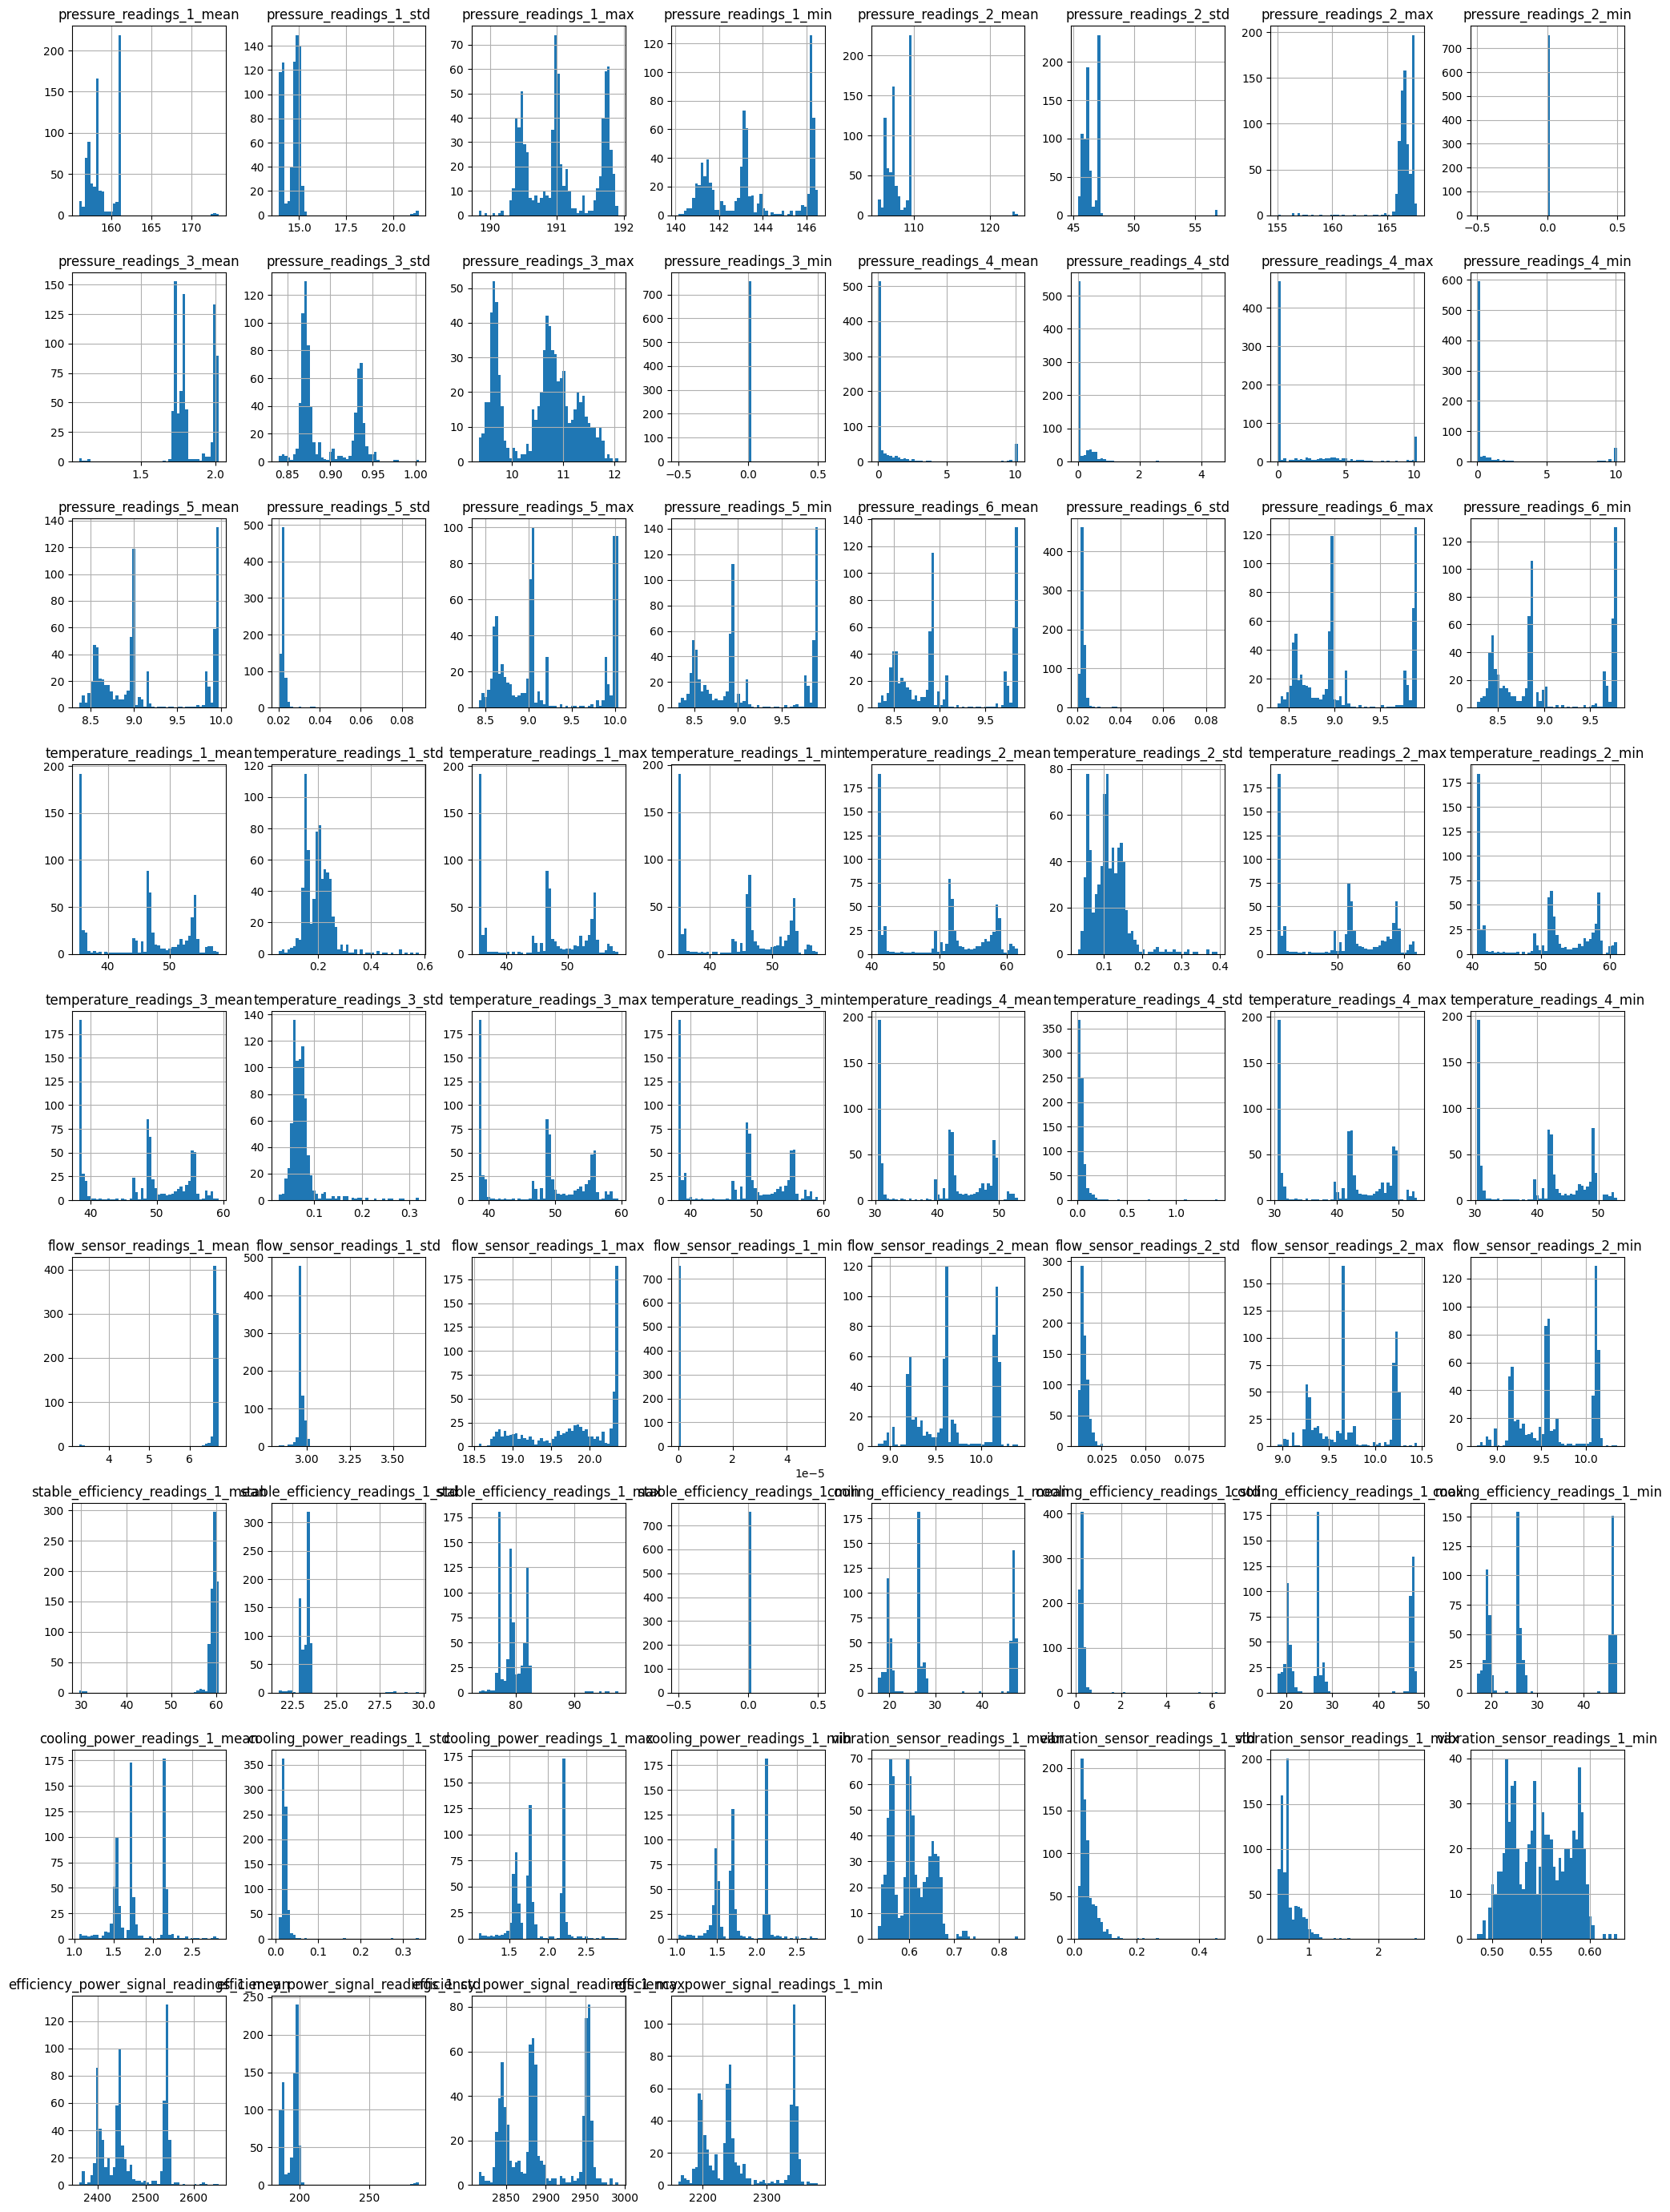

In [259]:
# Visualizing features data for redundant features
def visualizing_features():
    X.hist(bins=50,figsize=(25,35))

visualizing_features()    

In [260]:
# dropping redundant features
def removing_redundant_features_columns(X):
    columns = ['pressure_readings_2_min','pressure_readings_3_min','flow_sensor_readings_1_min','stable_efficiency_readings_1_min']
    X = X.drop(columns=columns)
    return X

X = removing_redundant_features_columns(X)

X.head()

,pressure_readings_1_mean,pressure_readings_1_std,pressure_readings_1_max,pressure_readings_1_min,pressure_readings_2_mean,pressure_readings_2_std,pressure_readings_2_max,pressure_readings_3_mean,pressure_readings_3_std,pressure_readings_3_max,...,cooling_power_readings_1_max,cooling_power_readings_1_min,vibration_sensor_readings_1_mean,vibration_sensor_readings_1_std,vibration_sensor_readings_1_max,vibration_sensor_readings_1_min,efficiency_power_signal_readings_1_mean,efficiency_power_signal_readings_1_std,efficiency_power_signal_readings_1_max,efficiency_power_signal_readings_1_min
cycleid,,,,,,,,,,,,,,,,,,,,,
1,160.673492,13.938147,191.51,145.83,109.466914,47.110581,156.99,1.991475,0.945626,10.039,...,2.187962,1.383000,0.577008,0.026448,0.623983,0.532009,2538.929167,185.600652,2951.6,2339.8
2,160.603320,14.117791,191.47,145.73,109.354890,47.041690,157.56,1.976234,0.941889,9.992,...,1.414000,1.147035,0.565915,0.026670,0.625962,0.524021,2531.498900,189.924260,2947.4,2332.0
3,160.347720,14.191436,191.41,145.37,109.158845,46.988144,156.97,1.972224,0.943422,10.914,...,1.159000,1.076006,0.576878,0.036127,0.662000,0.529009,2519.928000,190.720954,2939.8,2318.6
4,160.188088,14.226617,191.34,145.14,109.064807,46.968307,156.44,1.946576,0.935456,10.297,...,1.106926,1.022001,0.569531,0.032960,0.644992,0.527003,2511.541633,191.254667,2929.6,2310.8
5,160.000472,14.275244,191.41,144.95,108.931434,46.871040,158.13,1.922707,0.930258,11.102,...,1.106000,1.016009,0.577767,0.032836,0.659975,0.524020,2503.449500,191.242430,2923.8,2301.8


In [261]:
# Feature Engineering
# creating features that affect cooling conditions
def create_cooler_conditions_features(X):
    X['Overall Temp Change'] = X['temperature_readings_1_mean']-X['temperature_readings_4_mean']
    X['Intermediate Temp Change'] = X['temperature_readings_2_mean']-X['temperature_readings_3_mean']
    X['Cooling Effectiveness Ratio'] = ((X['temperature_readings_1_mean']-X['temperature_readings_4_mean'])/X['temperature_readings_1_mean'])

create_cooler_conditions_features(X)

# creating features that affect pump leakage conditions
def create_pump_leakage_features(X):
    total_pressure_drop = ((X['pressure_readings_1_mean']-X['pressure_readings_2_mean']) + (X['pressure_readings_2_mean']-X['pressure_readings_3_mean']) +
                            (X['pressure_readings_3_mean']-X['pressure_readings_4_mean']) + (X['pressure_readings_4_mean']-X['pressure_readings_5_mean']) +
                            (X['pressure_readings_5_mean']-X['pressure_readings_6_mean']))
    X['Leakage Ratio_1'] =  ((X['pressure_readings_1_mean']-X['pressure_readings_2_mean'])/total_pressure_drop)
    X['Leakage Ratio_2'] =  ((X['pressure_readings_2_mean']-X['pressure_readings_3_mean'])/total_pressure_drop)
    X['Leakage Ratio_3'] =  ((X['pressure_readings_3_mean']-X['pressure_readings_4_mean'])/total_pressure_drop)
    X['Leakage Ratio_4'] =  ((X['pressure_readings_4_mean']-X['pressure_readings_5_mean'])/total_pressure_drop)
    X['Leakage Ratio_5'] =  ((X['pressure_readings_5_mean']-X['pressure_readings_6_mean'])/total_pressure_drop)
    X['Pessure Efficiency Index'] = ((X['pressure_readings_1_mean']-X['pressure_readings_6_mean'])/X['pressure_readings_1_mean'])

create_pump_leakage_features(X)

# creating features that affect accumulator condition
def create_accumulator_condition_features(X):
    X['Pressure drop across Acc'] = (X['pressure_readings_5_mean']-X['pressure_readings_6_mean'])
    X['Pressure ratio across Acc'] = (X['pressure_readings_5_mean']/X['pressure_readings_6_mean'])

create_accumulator_condition_features(X)   

X.head()


,pressure_readings_1_mean,pressure_readings_1_std,pressure_readings_1_max,pressure_readings_1_min,pressure_readings_2_mean,pressure_readings_2_std,pressure_readings_2_max,pressure_readings_3_mean,pressure_readings_3_std,pressure_readings_3_max,...,Intermediate Temp Change,Cooling Effectiveness Ratio,Leakage Ratio_1,Leakage Ratio_2,Leakage Ratio_3,Leakage Ratio_4,Leakage Ratio_5,Pessure Efficiency Index,Pressure drop across Acc,Pressure ratio across Acc
cycleid,,,,,,,,,,,,,,,,,,,,,
1,160.673492,13.938147,191.51,145.83,109.466914,47.110581,156.99,1.991475,0.945626,10.039,...,2.505388,0.108830,0.339239,0.712015,0.013193,-0.065204,0.000756,0.939454,0.114072,1.011726
2,160.603320,14.117791,191.47,145.73,109.354890,47.041690,157.56,1.976234,0.941889,9.992,...,2.551070,0.059412,0.339228,0.710769,0.013081,-0.063778,0.000699,0.940664,0.105654,1.011087
3,160.347720,14.191436,191.41,145.37,109.158845,46.988144,156.97,1.972224,0.943422,10.914,...,2.808268,0.058906,0.339179,0.710223,0.013068,-0.063150,0.000680,0.941203,0.102599,1.010882
4,160.188088,14.226617,191.34,145.14,109.064807,46.968307,156.44,1.946576,0.935456,10.297,...,3.000451,0.059071,0.338900,0.710095,0.012904,-0.062571,0.000672,0.941710,0.101397,1.010859
5,160.000472,14.275244,191.41,144.95,108.931434,46.871040,158.13,1.922707,0.930258,11.102,...,3.020811,0.059621,0.338789,0.709890,0.012755,-0.062086,0.000651,0.942121,0.098126,1.010596


In [262]:
# Feature Selection
# check correlation in order to remove highly correlated features
def show_correlation(X):    
    corr_matrix = X.corr()

    corr_pairs = corr_matrix.unstack().reset_index()
    corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
    corr_pairs = corr_pairs[corr_pairs['Feature_1'] != corr_pairs['Feature_2']]  # Remove self-correlations
    corr_pairs = corr_pairs.sort_values(by='Correlation', ascending=False).drop_duplicates(subset=['Correlation'])

    print(corr_pairs.head(40))  # Show the top 40 correlated feature pairs

show_correlation(X) 

                        Feature_1                    Feature_2  Correlation
1068     pressure_readings_5_mean     pressure_readings_6_mean     0.999993
2282  temperature_readings_3_mean   temperature_readings_3_max     0.999977
1516      pressure_readings_6_max      pressure_readings_5_max     0.999975
1296      pressure_readings_5_min      pressure_readings_6_min     0.999965
2283  temperature_readings_3_mean   temperature_readings_3_min     0.999965
1674  temperature_readings_1_mean   temperature_readings_1_max     0.999961
2126   temperature_readings_2_max  temperature_readings_2_mean     0.999958
1979  temperature_readings_2_mean   temperature_readings_2_min     0.999951
1897   temperature_readings_1_min  temperature_readings_1_mean     0.999906
1289      pressure_readings_5_min     pressure_readings_5_mean     0.999905
2507   temperature_readings_3_min   temperature_readings_3_max     0.999902
1367     pressure_readings_6_mean      pressure_readings_5_min     0.999899
1070     pre

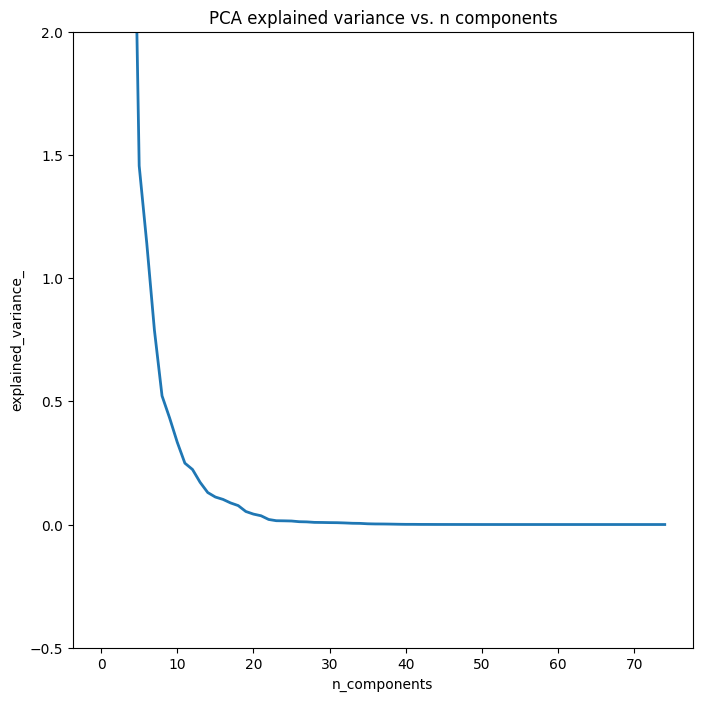

In [263]:
# Since we can see that they are so many correlated features, we proceed to employ PCA()
# Principal Component Analysis
def pca(X):
    # Standardizing the dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # applying the PCA without restrictions
    pca = PCA()
    pca.fit(X_scaled)
    # plot the vaiance
    plt.figure(figsize=(8,8))
    plt.plot(pca.explained_variance_,linewidth=2)
    plt.axis('tight')
    plt.xlabel('n_components')
    plt.ylabel('explained_variance_')
    plt.ylim(-0.5, 2)
    plt.title('PCA explained variance vs. n components')
    
pca(X)    

In [264]:

# from the graph its 12 to 13 n_components but lets find the cumulative variance of each to be sure
def confirm_pca(X):    
    # Standardizing the dataset
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # applying the PCA without restrictions
    pca = PCA()
    pca.fit(X_scaled)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    print(cumulative_variance[12])  # Check variance explained by 13th component
    print(cumulative_variance[13])  # Check variance explained by 14th component
    
confirm_pca(X)    

# selecting n_components = 12
def pca_reduction():
    # Standardizing the dataset
    scaler = StandardScaler()

    X_scaled = scaler.fit_transform(X)
    # Apply PCA with 13 components
    pca = PCA(n_components=12)
    X_pca = pca.fit_transform(X_scaled)  # Transform the original dataset

    return X_pca

X = pca_reduction()

0.9872228701575695
0.989503167246647


In [265]:
# converting my features from numpy arrays to pandas for convenience 
def convert_numpy_to_pandas(X):
    pca_column_names = [f"PC{i+1}" for i in range(12)]
    df_pca = pd.DataFrame(X[:, :12], columns=pca_column_names)
    return df_pca
X = convert_numpy_to_pandas(X)    

X.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,-5.431077,-3.273192,41.910893,7.018421,1.572874,-7.034066,-3.519856,-1.095183,0.649761,-6.947461,3.418062,0.554400
1,-3.011582,-1.167695,13.352356,-6.206671,-7.628552,1.491491,-0.498428,-0.894147,-1.008182,0.321951,-2.071982,-1.334658
2,-1.457529,-0.818464,11.337818,-7.423869,-8.792490,4.842556,1.431711,-0.861947,-0.102089,-0.514831,0.107564,-0.673716
3,-0.719699,-0.774174,11.511393,-7.352465,-8.960804,5.327171,2.328019,-0.602882,-0.391394,-0.394757,0.745433,-0.364313
4,0.054209,-0.579127,9.134609,-7.268250,-8.569903,5.296273,2.125907,-0.590028,-1.063612,0.863800,0.835649,0.044705


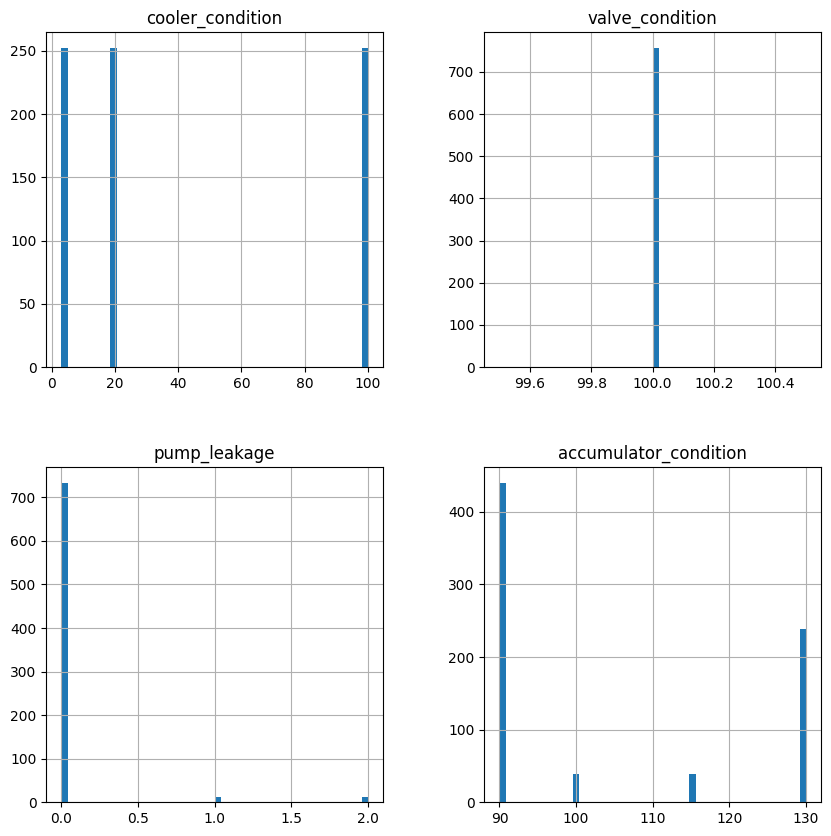

In [268]:
# preprocessing the target dataset
# visualizing the dataset
def visualizing_target_dataset():
    y.hist(bins=50,figsize=(10,10))

visualizing_target_dataset()

In [277]:
# removing columns that do not help the ML
def removing_redundant_targets_columns(y):
    y = y.drop(columns='stable_flag')
    y = y.drop(columns='valve_condition')
    return y

y = removing_redundant_targets_columns(y)

# getting encoded values for multiclass dataset for svm
def onehot_encode_y(y):
    y_copy = y.copy()
    y_copy = pd.get_dummies(y_copy, columns=['cooler_condition','pump_leakage','accumulator_condition'])
    y_copy.index = X.index
    return y_copy# Check encoded labels

y_svm = onehot_encode_y(y)

# getting label encoded values for xgboost and randomforest
def label_encoder(y):
    y_copy = y.copy()
    # Initialize LabelEncoder
    label_enc = LabelEncoder()
    # Encode each categorical target column
    y_copy['cooler_condition'] = label_enc.fit_transform(y_copy['cooler_condition'])
    y_copy['pump_leakage'] = label_enc.fit_transform(y_copy['pump_leakage'])
    y_copy['accumulator_condition'] = label_enc.fit_transform(y_copy['accumulator_condition'])
    y_copy.index = X.index
    return y_copy  # Check label-encoded targets

y_rf_xgb = label_encoder(y)    



In [278]:
y_svm.head()

,cooler_condition_3,cooler_condition_20,cooler_condition_100,pump_leakage_0,pump_leakage_1,pump_leakage_2,accumulator_condition_90,accumulator_condition_100,accumulator_condition_115,accumulator_condition_130
0,True,False,False,True,False,False,False,False,False,True
1,True,False,False,True,False,False,False,False,False,True
2,True,False,False,True,False,False,False,False,False,True
3,True,False,False,True,False,False,False,False,False,True
4,True,False,False,True,False,False,False,False,False,True


In [279]:
y_rf_xgb.head()

,cooler_condition,pump_leakage,accumulator_condition
0,0,0,3
1,0,0,3
2,0,0,3
3,0,0,3
4,0,0,3
